**To-Do:**
- Backpropagation
- Loss
- Gradient Descent
- Weight import

In [350]:
from numpy.typing import NDArray
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras

In [351]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")

x_train = np.reshape(x_train, (x_train.shape[0], -1)) / 255

# n: Number of train images
# m: Number of pixels
# m_t: Number of test images
m,n = x_train.shape

def one_hot_encoding(size, Y):
    ny = np.zeros(size)
    for i in range(size[0]):
        ny[i,Y[i]] = 1
    return ny

y_train = (one_hot_encoding((m,10), y_train)).T
x_train = x_train.T

In [352]:
class Scalar:

    @staticmethod
    def z_score(data: NDArray[np.float64]) -> NDArray[np.float64]:
        mean: int = np.mean(data, axis=0)
        std: int = np.std(data, axis=0)
        std[std == 0] = 1
        return (data - mean) / std

In [353]:
class Layer:
    __supported_activations: list[str] = ["linear","relu","softmax"]

    def __init__(self, size: int, activation: str = "linear") -> None:
        if activation not in Layer.__supported_activations:
            raise ValueError(f"Parameter 'activation' not supported, please enter one of the following: {', '.join(Layer.__supported_activations)}")
        self.__size: int = size
        self.__activation: str = activation
        self.__parent: Layer = None
        self.__child: Layer = None

    def __str__(self) -> str:
        return f"ID: {self.__id} | Neurons: {self.__size} | Activation: {self.__activation}"

    def set_parent(self, parent: "Layer") -> None:
        self.__parent = parent

    def get_parent(self) -> "Layer":
        return self.__parent

    def set_child(self, child: "Layer") -> None:
        self.__child = child

    def get_child(self) -> "Layer":
        return self.__child

    def set_id(self, id: int) -> None:
        self.__id = id

    def get_id(self) -> int:
        return self.__id

    def get_size(self) -> int:
        return self.__size

    def get_activation(self) -> str:
        return self.__activation
    
    def get_z(self) -> NDArray[np.float64]:
        return self.__Z

    def set_z(self, Z: NDArray[np.float64]) -> None:
        self.__Z: NDArray[np.float64] = Z

    # New layers
    def set_neurons(self) -> None:
        if self.__parent:
            parent_size: int = self.__parent.get_size()
            self.__W: NDArray[np.float64] = np.random.normal(0, 0.01, size=(self.__size, parent_size))
            self.__B: NDArray[np.float64] = np.random.normal(0, 0.01, size=(self.__size, 1))
            self.__A: NDArray[np.float64] = np.zeros((self.__size, 1))
        else:
            self.__W: NDArray[np.float64] = None
            self.__B: NDArray[np.float64] = None
            self.__A: NDArray[np.float64] = None

    def get_value(self) -> NDArray[np.float64]:
        return self.__A
    
    def get_parameters(self) -> list[NDArray[np.float64]]:
        return self.__W, self.__B
    
    def update_parameters(self, learning_rate: float, dW: NDArray[np.float64], dB: NDArray[np.float64]):
        self.__W -= learning_rate * dW
        self.__B -= learning_rate * dB

    def set_input(self, input: NDArray[np.float64]) -> None:
        self.__A  = input

    def g(self, input: NDArray[np.float64]) -> NDArray[np.float64]:
        if self.__activation == "relu":
            return np.maximum(input, 0)
        elif self.__activation == "softmax":
            input = np.clip(input, -700, 700)
            nominator: NDArray[np.float64] = np.exp(input)
            denominator: int = np.sum(nominator)
            return nominator / denominator
        else:
            return input

    def forward(self) -> None:
        self.__A = self.g(np.matmul(self.__W, self.__parent.get_value()) + self.__B)


In [354]:
class Loss:
    __supported_losses: list[str] = ["CCEL"]
    __supported_regularizations: list[str] = ["none", "L2"]

    def __init__(self, loss: str = "CCEL", learning_rate: float = 1e-3, regularization: str = "none", lambda_: float = 0.01) -> None:
        if loss not in Loss.__supported_losses:
            raise ValueError(f"Parameter 'loss' not supported, please enter one of the following: {', '.join(Loss.__supported_losses)}")
        if regularization not in Loss.__supported_regularizations:
            raise ValueError(f"Parameter 'regularization' not supported, please enter one of the following: {', '.join(Loss.__supported_regularizations)}")
        
        self.__loss: str = loss
        self.__learning_rate: float = learning_rate
        self.__regularization: str = regularization
        self.__lambda: float = lambda_
    
    def get_loss(self) -> str:
        return self.__loss
    
    def get_learning_rate(self) -> float:
        return self.__learning_rate
    
    def get_regularization(self) -> str:
        return self.__regularization
    
    def get_lambda(self) -> float:
        return self.__lambda

    def loss_computation(self, layers: list[Layer], target: NDArray[np.float64]) -> float:
        loss_value: float = 0.0
        
        # Categorical Cross-Entropy Loss Computation
        if self.__loss == "CCEL":
            predictions: NDArray[np.float64] = layers[-1].get_value()
            predictions = np.clip(predictions, 1e-7, 1 - 1e-7)
            loss_value -= np.sum(target * np.log(predictions)) / (2 * predictions.shape[1])
        
        # L2 Regularization
        if self.__regularization == "L2":
            l2_loss: float = 0.0
            for layer in layers:
                W, _ = layer.get_parameters()
                if W is not None:
                    l2_loss += np.sum(W ** 2) / 2
            loss_value += self.__lambda * l2_loss

        return loss_value

In [355]:
class NeuralNetwork:

    def __init__(self) -> None:
        self.__layers: list[Layer] = []

    def __str__(self) -> str:
        layers_str = "\n".join(f"\t{layer}" for layer in self.__layers)
        return f"Neural Network:\n{layers_str}\nTotal of Parameters: {self.get_num_of_parameters()}"
    
    def get_num_of_parameters(self) -> int:
        num: int = 0
        for layer in self.__layers:
            W, B = layer.get_parameters()
            if W is not None and B is not None:
                num += W.shape[0] * W.shape[1] + B.shape[0]
        return num

    # Hidden layers can only be linear or ReLU
    def build(self, layers: list[Layer]) -> None:
        self.__layers: list[Layer] = layers
        # Updating layers' relationships
        current: Layer = None
        id: int = 0
        for layer in layers:
            if current:
                current.set_child(layer)
                layer.set_parent(current)
            layer.set_id(id)
            id += 1
            current = layer

    def fit_data(self, input: NDArray[np.float64], target: NDArray[np.float64]) -> None:
        # An input with P features and Q examples should have the shape (P,Q)
        # A target should have the shape (K,Q)
        if input.shape[0] != self.__layers[0].get_size():
            raise ValueError(f"At the input layer, supported size is: ({self.__layers[0].get_size()},n), received: {input.shape}")
        if target.shape[0] != self.__layers[-1].get_size():
            raise ValueError(f"At the target layer, supported size is: ({self.__layers[-1].get_size()},1), received: {target.shape}")
        
        self.__input: NDArray[np.float64] = input
        self.__target: NDArray[np.float64] = target
        
        # Creating weight matrix W, bias vector B, and value vector A for every layer
        # For a specifc layer containing K neurons, having a parent layer containing N neurons:
        # W shape: (K,N) | B shape: (K,1) | A shape: (K,1)
        for layer in self.__layers:
            layer.set_neurons()

    def forward_propagation_by_index(self, index: int) -> None:
        for layer in self.__layers:
            if layer.get_parent():
                layer.forward()
            else:
                layer.set_input(self.__input[:,index].reshape(-1,1))

    # def forward_propagation(self, input: NDArray) -> None:
    #     for layer in self.__layers:
    #         if layer.get_parent():
    #             layer.forward()
    #         else:
    #             layer.set_input(input)

    def back_propagation(self, target_index: int) -> None:
        if self.__loss.get_loss() == "CCEL":
            # Output layer gradient for CCEL with Softmax
            output_layer = self.__layers[-1]
            output_layer.set_z(output_layer.get_value() - self.__target[:, target_index].reshape(-1, 1))

            # Backpropagate through hidden layers
            for i in range(len(self.__layers) - 2, -1, -1):
                layer: Layer = self.__layers[i]
                child_layer: Layer = self.__layers[i + 1]

                # dA (Gradient of loss with respect to layer's activations)
                dA: NDArray[np.float64] = np.matmul(child_layer.get_parameters()[0].T, child_layer.get_z())

                if layer.get_activation() == "relu":
                    dZ: NDArray[np.float64] = dA * (layer.get_value() > 0)
                else:
                    dZ: NDArray[np.float64] = dA
                
                layer.set_z(dZ)
        
            # Updating parameters
            learning_rate: float = self.__loss.get_learning_rate()
            for layer in self.__layers:
                if layer.get_parent():

                    dW: NDArray[np.float64] = np.matmul(layer.get_z(), layer.get_parent().get_value().T)
                    dB: NDArray[np.float64] = np.sum(layer.get_z(), axis=1, keepdims=True)

                    if self.__loss.get_regularization() == "L2":
                        lambda_ = self.__loss.get_lambda()
                        dW += lambda_ * layer.get_parameters()[0]

                    layer.update_parameters(learning_rate, dW, dB)

    def train(self, epochs: int, loss: Loss = Loss()):
        self.__loss: Loss = loss

        loss_hist: list[float] = []
        for _ in tqdm(range(epochs)):
            for i in range(self.__input.shape[1]):
                self.forward_propagation_by_index(i)
                self.back_propagation(i)
                loss_hist.append(self.__loss.loss_computation(self.__layers, self.__target[:,i]))
        return loss_hist

    def get_results(self) -> NDArray[np.float64]:
        return self.__layers[-1].get_value()

Neural Network:
	ID: 0 | Neurons: 784 | Activation: linear
	ID: 1 | Neurons: 32 | Activation: linear
	ID: 2 | Neurons: 32 | Activation: linear
	ID: 3 | Neurons: 10 | Activation: softmax
Total of Parameters: 26506


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\davis\AppData\Local\Temp\ipykernel_8576\88436457.py:82: RuntimeWarning: overflow encountered in matmul
  self.__A = self.g(np.matmul(self.__W, self.__parent.get_value()) + self.__B)
C:\Users\davis\AppData\Local\Temp\ipykernel_8576\232270705.py:75: RuntimeWarning: overflow encountered in matmul
  dA: NDArray[np.float64] = np.matmul(child_layer.get_parameters()[0].T, child_layer.get_z())
C:\Users\davis\AppData\Local\Temp\ipykernel_8576\4232556430.py:43: RuntimeWarning: overflow encountered in square
  l2_loss += np.sum(W ** 2) / 2
C:\Users\davis\AppData\Local\Temp\ipykernel_8576\232270705.py:89: RuntimeWarning: overflow encountered in matmul
  dW: NDArray[np.float64] = np.matmul(layer.get_z(), layer.get_parent().get_value().T)
C:\Users\davis\AppData\Local\Temp\ipykernel_8576\88436457.py:82: RuntimeWarning: invalid value encountered in matmul
  self.__A = self.g(np.matmul(self.__W, self.__parent.get_value()) + self.__B)
100%|██████████| 1/1 [0

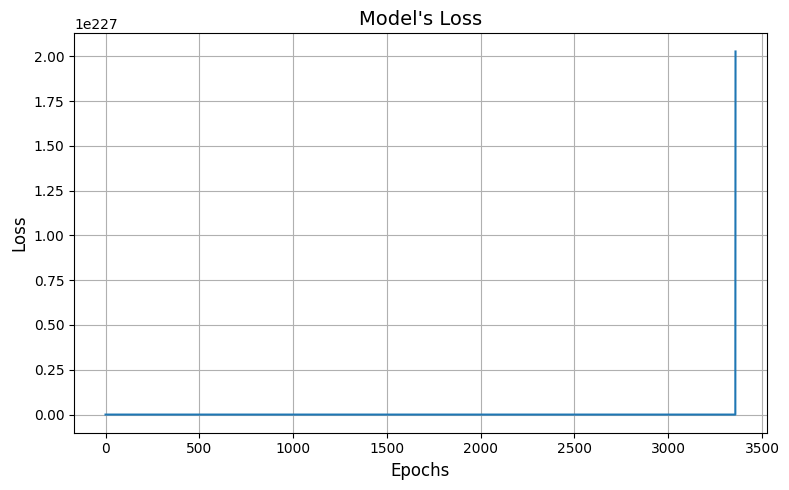

In [ ]:
test = NeuralNetwork()
test.build([
    Layer(784),
    Layer(10,"softmax")
])

scaled_x = Scalar().z_score(x_train)
scaled_y = Scalar().z_score(y_train)
test.fit_data(scaled_x,scaled_y)

print(test)

epochs = 1
loss_hist = test.train(epochs, Loss(regularization="L2"))

plt.figure(figsize=(8, 5))
plt.plot(range(len(loss_hist)), loss_hist)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Model's Loss", fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()